# ID2222 Data Mining, Homework 3
# **Mining Data Streams - TRIEST IMPR**

Brando Chiminelli, Tommaso Praturlon

November 28th, 2022

## Import libraries and read the dataset
In the following we import the few libraries needed for the project and we read the dataset.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

#PATH_TO_DATA = "../data/web-Stanford.txt"
PATH_TO_DATA = "../data/facebook_combined.txt"
df_graphs = pd.read_csv(PATH_TO_DATA, header=None)
print("Data read successfully!")

# Reduce dataset size for computation overload (temporary)
#df_graphs = df_graphs.iloc[0:50000]
print(df_graphs.head())
print("Number of rows: ", len(df_graphs))

Data read successfully!
     0
0  0 1
1  0 2
2  0 3
3  0 4
4  0 5
Number of rows:  88234


## Data Wrangling

In the following we want to transorm our dataset to make it more clean to read and process.

We do that both for the Social circles Facebook dataset and for the Stanford web graph, by removing some rows that are not needed (general statistics about the data) and converting the values into integers.

In [3]:
# DATA WRANGLING FACEBOOK

df_g = df_graphs
data = []
for i in range(len(df_g)):
    # make the two elements a tuple
    s = tuple(str(df_g.iloc[i][0]).split(' '))
    data.append(s)
#print(data)

In [ ]:
'''
# DATA WRANGLING STANFORD

df_g = df_graphs.drop([0, 1, 2, 3, 4])
data = []
for i in range(len(df_g)):
    s = [int(x) for x in str(df_g.iloc[i][0]).split('\t')]
    data.append(s)
#print(data)
'''

## TRIEST IMPR Class

Our implementation of the Triest Impr class has the same three main functions of Triest Base but with the following differences:

- **run_triest** which takes one edge at a time from our dataset as a stream, run the algorithm and return the counters and the estimated value of triangles. The difference with this version is that *updateCounters* is called unconditionally for each element on the stream, before the algorithm decides whether or not to insert the edge into S

- **sampleEdge** uses the reservoir sampling process to update the edge sample, and each edge item in the sample has equal probability.

- **updateCounters** in the Impr version only increments the values of the global and local counters, no matter whether the operation of the edge was an insertion or deletion. It also performs a weighted increase of the counters using η(t) = max{1,(t − 1)(t − 2)/(M(M − 1))} as weight.


In [5]:
####################################
# TRIEST-BASE CLASS IMPLEMENTATION #
####################################

class TriestBase:
    '''
    Implementation of the Trièst-base algorithm
    - function SampleEdge
    - function UpdateCounter
    - function FlipBiasedCoin
    '''
    
    def __init__(self,M):
        self._M = M
        self._tau = 0
        self._tau_loc = {}
        self._t = 0
        self._S = set()
        self._tau_ls = []

    def flipBiasedCoin(self, M, t):
    # def flipBiasedCoin(self):
        '''
        Flip a biased coin with probability M/t of falling head.
        '''
        # 1: head, 0: tail
        result = np.random.choice([1, 0], p=[M/t, (1-M/t)])

        if result:
            return True
        else:
            return False

    def sampleEdge(self, t):
        '''
        Receives the edge (u,v) as [u, v] and time t at which
        the stream element is received. t is a count integer.
        Returns a boolean
        '''
        
        if (t <= self._M):
            #print(f"t: {self._t}, M: {self._M}")
            return True
        elif self.flipBiasedCoin(self._M, t):
            # select random edge from S
            random_edge = random.choice(tuple(self._S))
            # Delete random_edge from S
            self._S.remove(random_edge)
            return True
        else:
            return False
            
    def updateCounters(self, t, edge):
        '''
        Receives the operation insertion or deletion
        and the edge.
        tau is the global counter
        e.g S = [[5,10], [10, 3], [12, 5], [12, 3]]
        edge = (5, 12)
        N_5 = (10, 12)
        N_12 = (5, 3)
        N_5_12 = (5, 12)
        '''
        # Define shared-neighborhood
        shared_neigh = set()
        neigh_u = set() # all neighbors of edge[0]
        neigh_v = set() # all nneighbors of edge[1]

        u = edge[0]
        v = edge[1]
        for elem in self._S:
            # check that for the v in V_t (u,v) belongs to S
            # create neigh_u
            if u == elem[0]: # found u in position 0
                neigh_u.add(elem[1]) # add the other element
            if u == elem[1]: # found u in position 1
                neigh_u.add(elem[0]) # add the other element
            # create neigh_v
            if v == elem[0]: # found v in position 0
                neigh_v.add(elem[1]) 
            if v == elem[1]: # found v in position 1
                neigh_v.add(elem[0])
        # shared neighbourhood is the intersection between the sets
        shared_neigh = set.intersection(neigh_u, neigh_v)
        self._tau_ls.append(self._tau)

        #IMPR version only increments the counters and uses a weight
        _weight = ((t - 1) * (t - 2)) / (self._M * (self._M - 1))
        weight = max(1, _weight)
        for c in shared_neigh:
            self._tau += weight
            self._tau_loc[c] = self._tau_loc.get(c, 0) + weight
            self._tau_loc[u] = self._tau_loc.get(u, 0) + weight
            self._tau_loc[v] = self._tau_loc.get(v, 0) + weight

                    
    def run_triest(self, data):
        print("Number of edges: ", len(data))
        for edge in data:
            self._t += 1
            # IMPR version calls the updateCounters before the if cycle
            self.updateCounters(self._t, edge)
            if self.sampleEdge(self._t):
                # self._S.append(edge)
                self._S.add(edge)
                
        # Return counters
        est_tri = self._tau
        print("Estimated triangles: ", est_tri)
        plt.plot(range(len(self._tau_ls)), self._tau_ls)
        plt.show()

## Execution

We can note from the output that the estimated triangles is very close to the one reported on the website where we took the dataset (1612010 triangles).

Number of edges:  88234
Estimated triangles:  1634821.9300549272


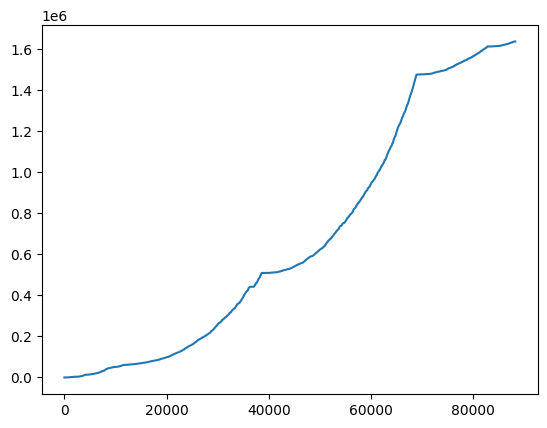

In [6]:
# EXPLOITING THE CLASS TRIEST-BASE
TriestBase(10000).run_triest(data)